In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
%matplotlib inline
from sklearn import preprocessing

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [138]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [139]:
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


## Data Exploration

In [3]:
combine = [train, test]
for df in combine:
    print (df.info())
    print ('-'*50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket      

In [141]:
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Odahl, Mr. Nils Martin",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [142]:
print(train.pivot_table(values='Survived', columns='Sex', index=['Pclass'], aggfunc='mean'))
print('-'*30)
print(train.pivot_table(values='Survived', columns='Sex', index=['Embarked'], aggfunc='mean'))

Sex       female      male
Pclass                    
1       0.968085  0.368852
2       0.921053  0.157407
3       0.500000  0.135447
------------------------------
Sex         female      male
Embarked                    
C         0.876712  0.305263
Q         0.750000  0.073171
S         0.689655  0.174603


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025C257193C8>]], dtype=object)

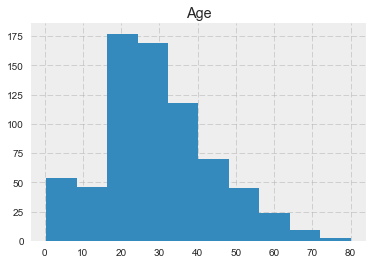

In [143]:
train.hist(column='Age', bins=10)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

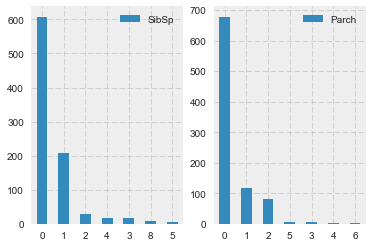

In [144]:
plt.subplot2grid((1, 2), (0, 0))
train['SibSp'].value_counts().plot(kind='bar').legend()
plt.xticks(rotation='0')

plt.subplot2grid((1, 2), (0, 1))
train['Parch'].value_counts().plot(kind='bar').legend()
plt.xticks(rotation='0')

## Modifying Features

#### Adding new feature 'Family Size'

In [4]:
for df in combine:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
train['FamilySize'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64

#### Adding new feature 'Alone'

In [5]:
for df in combine:
    df['Alone'] = 0
    df.loc[df['FamilySize'] == 1, 'Alone'] = 1
    
train['Alone'].value_counts()

1    537
0    354
Name: Alone, dtype: int64

#### Filling missing values for 'Embarked'

In [6]:
for df in combine:
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    
train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

#### 'Fare': Filling missing values, grouping values

In [7]:
for df in combine:
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    df['FareGroups'] = pd.qcut(df['Fare'], 4)
train[['FareGroups', 'Survived']].groupby('FareGroups', as_index=False).mean()

,FareGroups,Survived
0,"[0, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31]",0.454955
3,"(31, 512.329]",0.581081


####  'Age': Filling missing values, grouping values

In [8]:
for df in combine:
    avg = df['Age'].mean()
    std = df['Age'].std()
    NaN_count = df['Age'].isnull().sum()
    
    age_fill = np.random.randint(avg-std, avg+std, NaN_count)
    df.loc[df['Age'].isnull(), 'Age'] = age_fill
    df['Age'] = df['Age'].astype(int)
    df['AgeGroups'] = pd.cut(df['Age'], 5)
    
train[['AgeGroups', 'Survived']].groupby('AgeGroups').mean()

,Survived
AgeGroups,
"(-0.08, 16]",0.500000
"(16, 32]",0.358447
"(32, 48]",0.372549
"(48, 64]",0.434783
"(64, 80]",0.090909


#### 'Name': Extracting titles

In [9]:
import re

def only_title(name):
    title = re.findall(' ([A-Za-z]+)\.', name)
    if title:
        return title[0]

for df in combine:
    df['Title'] = df['Name'].apply(only_title)
    
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Don           1
Mme           1
Jonkheer      1
Capt          1
Countess      1
Lady          1
Sir           1
Ms            1
Name: Title, dtype: int64

In [151]:
for df in combine:
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 
                                     'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby('Title', as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


### Data Encoding

In [152]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone,FareGroups,AgeGroups,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,2,0,"[0, 7.91]","(16, 32]",Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,2,0,"(31, 512.329]","(32, 48]",Mrs


In [10]:
feature_drop = ['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'FamilySize']

for df in combine:
    df.drop(feature_drop, axis=1, inplace=True)

train.head(2)

,Survived,Pclass,Sex,Embarked,Alone,FareGroups,AgeGroups,Title
0,0,3,male,S,0,"[0, 7.91]","(16, 32]",Mr
1,1,1,female,C,0,"(31, 512.329]","(32, 48]",Mrs


In [11]:
def encode_features(train, test):
    features = ['Sex', 'Embarked', 'FareGroups', 'AgeGroups', 'Title']
    df_combined = pd.concat([train[features], test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        train[feature] = le.transform(train[feature])
        test[feature] = le.transform(test[feature])
    return train, test
    
train, test = encode_features(train, test)
train.head()

,Survived,Pclass,Sex,Embarked,Alone,FareGroups,AgeGroups,Title
0,0,3,1,2,0,7,3,13
1,1,1,0,0,0,2,5,14
2,1,3,0,2,1,5,3,10
3,1,1,0,2,0,2,5,14
4,0,3,1,2,1,5,5,13


#### Feature heatmap

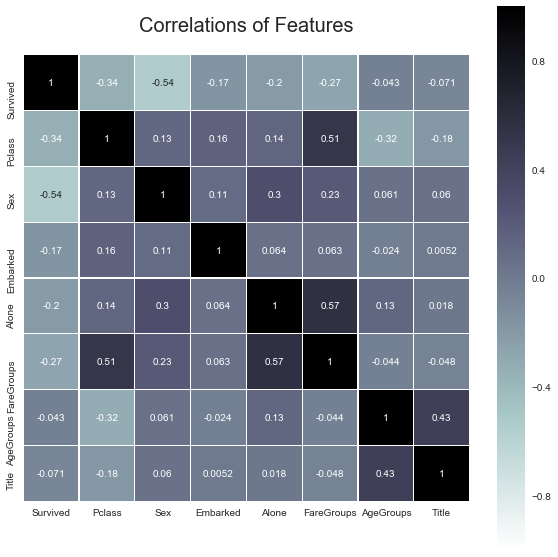

In [155]:
colormap = plt.cm.bone_r
plt.figure(figsize=(10,10))
plt.title('Correlations of Features', y=1.04, size=20)
sns.heatmap(train.astype(float).corr(), square=True, cmap=colormap, annot=True, linewidth=0.2)

## Train Models

### Data Splitting

In [12]:
X = train.drop(['Survived'], axis=1)
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=2017)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)
print('Null Accuracy for y_test dataset:', y_test.value_counts()[1]/len(y_test))

X_train (712, 7)
X_test (179, 7)
y_train (712,)
y_test (179,)
Null Accuracy for y_test dataset: 0.296089385475


In [258]:
# Accuracy on Test data
def (model_accuracy)(model):
    model_y_pred_class = model.predict(X_test)
    accuracy_out = metrics.accuracy_score(y_test, model_y_pred_class)
    return accuracy_out

# Cross_val_score on Test data
def mean_cv_score(model):
    cv_scores = cross_val_score(model, X_test, y_test, cv=10, scoring='accuracy')
    mean_score = cv_scores.mean()
    return mean_score

# AUC score on Test data
def auc_score(model):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    auc = metrics.roc_auc_score(y_test, y_pred_prob)
    return auc

# Confusion Matrix on Test data
def confusion_matrix(model):
    model_y_pred_class = model.predict(X_test)
    c_m = metrics.confusion_matrix(y_test, model_y_pred_class)
    return c_m

# Sensitivity
def sensitivity(model):
    model_y_pred_class = model.predict(X_test)
    sen = metrics.recall_score(y_test, model_y_pred_class)
    return sen

### SVM

In [259]:
svc = SVC(probability=True)
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Logistic regression

In [260]:
logreg = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(logreg, param_grid, cv=10)
grid_fit = grid.fit(X_train, y_train)

In [261]:
logreg = grid_fit.best_estimator_
logreg.fit(X_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Random Forest

In [262]:
rf = RandomForestClassifier()

parameters = {'n_estimators': [10, 20, 30, 40], 'max_features':['auto', 'sqrt', None],  
              'criterion':['gini', 'entropy'], }
grid = GridSearchCV(rf, param_grid=parameters, cv=10, n_jobs=-1)
grid_fit = grid.fit(X_train, y_train)

In [263]:
rf = grid_fit.best_estimator_
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### KNN

In [264]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors':list(range(1,15)), 'weights':['distance', 'uniform']}
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_fit = grid.fit(X_train, y_train)

In [265]:
knn = grid_fit.best_estimator_
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

### Extra Trees

In [266]:
et = RandomForestClassifier()

parameters = {'n_estimators': [10, 20, 30, 40, 50], 'max_features':['auto', 'sqrt', None], 
              'criterion':['gini', 'entropy']}
grid = GridSearchCV(et, param_grid=parameters, cv=10, n_jobs=-1)
grid_fit = grid.fit(X_train, y_train)

In [267]:
et = grid_fit.best_estimator_
et.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Models Comparisons

In [305]:
models = [svc, logreg, rf, knn, et]
model_names = ['svc', 'logreg', 'rf', 'knn', 'et']
model_dict = dict(zip(model_names, models))

In [309]:
[print(item, 'accuracy:', model_accuracy(model_dict[item])) for item in model_dict]

svc accuracy: 0.849162011173
logreg accuracy: 0.821229050279
rf accuracy: 0.837988826816
knn accuracy: 0.821229050279
et accuracy: 0.826815642458


[None, None, None, None, None]

In [311]:
[print(item, 'mean_cv_score:', mean_cv_score(model_dict[item])) for item in model_dict]

svc mean_cv_score: 0.798606811146
logreg mean_cv_score: 0.832954936361
rf mean_cv_score: 0.84348125215
knn mean_cv_score: 0.827468180255
et mean_cv_score: 0.838871689026


[None, None, None, None, None]

In [312]:
[print(item,'sensitivity:', sensitivity(model_dict[item])) for item in model_dict]

svc sensitivity: 0.792452830189
logreg sensitivity: 0.754716981132
rf sensitivity: 0.754716981132
knn sensitivity: 0.754716981132
et sensitivity: 0.735849056604


[None, None, None, None, None]

# Voting Classifier

In [272]:
vclf = VotingClassifier(estimators=[('svc', svc), ('logreg', logreg), ('rf', rf), ('knn', knn)])

param_grid = {'voting':['hard', 'soft']}
grid = GridSearchCV(vclf, param_grid, cv=10, n_jobs=-1)
grid_fit = grid.fit(X_train, y_train)

In [273]:
vclf = grid_fit.best_estimator_
vclf.fit(X_train, y_train)

VotingClassifier(estimators=[('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)), ('logreg', LogisticRegression(C=100, class_weight=None,...wski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance'))],
         n_jobs=1, voting='hard', weights=None)

# Output

In [274]:
vclf.fit(X, y)
pred = vclf.predict(test)

In [275]:
test_id = pd.read_csv('test.csv')['PassengerId']

output = pd.DataFrame({'PassengerId' : test_id, 'Survived': pred})

In [276]:
output.to_csv('Predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
